# BASELINE UNET
https://paperswithcode.com/paper/u-net-convolutional-networks-for-biomedical

In [3]:
import torch
import time
from tqdm import tqdm
import imageio
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

from functools import cmp_to_key
from pathlib import Path
from pycocotools.coco import COCO
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

import segmentation_models_pytorch as smp

In [10]:
torch.

True

In [2]:
print("Torch", torch.__version__)

DEVICE = 'mps'
def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Torch 1.13.1


In [3]:
DATA_ROOT = Path('../Data/test')
IMAGES = DATA_ROOT / Path('images')
MASKS = DATA_ROOT / Path('masks')
LABELS = ['background', 'car', 'wheel', 'lights', 'window']

In [4]:
img_list = list(IMAGES.glob('*'))
mask_list = list(MASKS.glob('*'))

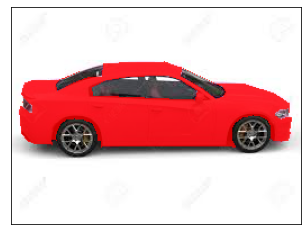

In [5]:
# посмотрим на маску кузова
idx = np.random.randint(0, len(img_list))

img_path = img_list[idx]
mask_path = mask_list[idx]

img = make_grid(read_image(str(img_path)))
# бывает, что у изображения 4 канала
if img.size()[0] == 4:
    img = img[:3, :, :]

mask = read_image(str(mask_path))

# 1 - это маска кузова авто
mask_body = mask == 1

drawn_masks = []
drawn_masks.append(draw_segmentation_masks(img, mask_body, alpha=0.8, colors="red"))

show(drawn_masks)

In [7]:
# сортируем изображения по разрешению (чтобы в битче были изображения похожего разрешения)
def cmp_by_image_resolution(x, y):
    if x[2] > y[2]:
        return -1
    elif x[2] == y[2]:
        if x[3] > y[3]:
            return -1
        else:
            return 1
    else:
        return 1

class CarBodyDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform_img=None, transform_mask=None):
        assert len(img_paths) == len(mask_paths), \
            f'Кол-во картинок и масок к ним не совпадает {(len(img_paths), len(mask_paths))}'
        
        # сортируем изображения по разрешению (чтобы в битче были изображения похожего разрешения)
        img_with_size = []
        for i, path in enumerate(img_paths):
            chanels, height, width = read_image(str(path)).shape
            img_with_size.append((i, path, height, width))
            
        img_with_size.sort(key=cmp_to_key(cmp_by_image_resolution))
        new_sort_idx = [x[0] for x in img_with_size]
        
        self.len_dataset = len(img_paths)
        self.img_paths = np.array(img_paths)[new_sort_idx]
        self.mask_paths = np.array(mask_paths)[new_sort_idx]
        self._transform_img = transform_img
        self._transform_mask = transform_mask
        
    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, idx):
        img = read_image(str(self.img_paths[idx]))
        # бывает, что у изображения 4 канала
        if img.size()[0] == 4:
            img = img[:3, :, :]
        
        mask = read_image(str(self.mask_paths[idx]))
        # 1 - это маска кузова авто
        mask_body = mask == 1
        
        if self._transform_img:
            img = self._transform_img(img)
        
        if self._transform_mask:
            mask_body = self._transform_mask(mask_body)
        
        sample = {'img': img, 'mask': mask_body}
        return sample
    

    


In [8]:
# img_list
# mask_list
def train_test_split(img_list: list, mask_list:list, size: float, permute=False) -> (list, list, list, list):
    """
    return: train_img_list, test_img_list, train_mask_list, test_mask_list
    """
    assert len(img_list) == len(mask_list), \
            f'Кол-во картинок и масок к ним не совпадает {(len(img_list), len(mask_list))}'
    assert 0 <= size <= 1, 'параметр size от 0 до 1' 
    
    train_size = round(len(img_list) * size)
    if permute:
        idx = np.random.permutation(len(img_list))
    else: 
        idx = list(range(len(img_list)))
    img_list_narray = np.array(img_list)
    permute_img_list = img_list_narray[idx]
    
    mask_list_narray = np.array(mask_list)
    permute_mask_list = mask_list_narray[idx]
    
    return permute_img_list[:train_size], permute_img_list[train_size:], \
        permute_mask_list[:train_size], permute_mask_list[train_size:]


In [9]:
class Padding(object):
    def __init__(self, first_conv_layer_size):
        self._conv_size = first_conv_layer_size
        
    def __call__(self, image):
        image += 1e-5
        chanels, height, width = image.shape
        
        pad_vertical = (self._conv_size - height % self._conv_size)
        pad_horizontal = (self._conv_size - width % self._conv_size)
        
        pad_top = pad_bot = int(pad_vertical / 2)
        if pad_vertical % 2:
            pad_top += 1

        pad_left = pad_right = int(pad_horizontal / 2)
        if pad_horizontal % 2:
            pad_left += 1

        pad = nn.ZeroPad2d(map(int, (pad_left, pad_right, pad_top, pad_bot)))
        resize_image = pad(torch.Tensor(image))
        assert resize_image.size()[1] % 32 == 0
        assert resize_image.size()[2] % 32 == 0
        return resize_image

    
def remove_borders_inplace(mask):
    mask[mask == 255] = 0
    return mask

class ToFloatTensor(object):
    def __call__(self, img):
        return img.type('torch.FloatTensor')
# размер входных изображений долже быть кратен размеру первой свертки
trf_img = transforms.Compose([
    transforms.ColorJitter(0.7,0.7,0.7,0),
    ToFloatTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    Padding(32),
    # transforms.Normalize(mean = (0.5, ), std = (0,5 ))
])

trf_mask = transforms.Compose([
    
    ToFloatTensor(),
    Padding(32),
])


In [12]:
imgs_train, imgs_test, mask_train, mask_test = train_test_split(img_list, mask_list, 0.8)

data_train = CarBodyDataset(imgs_train, mask_train, trf_img, trf_mask)
data_test = CarBodyDataset(imgs_test, mask_test, trf_img, trf_mask)

In [13]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(torch.nn.functional.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = torch.nn.functional.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data['img'], data['mask']
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            # print(f'output size {output.size()}')
            # print(f'mask size {mask.size()}')
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data['img'], data['mask']
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [36]:
max_lr = 1e-3
epoch = 2
weight_decay = 1e-4

train_loader = DataLoader(data_train, batch_size=1, shuffle=False)
test_loader = DataLoader(data_test, batch_size=1, shuffle=False)


device = 'mps'
#device = 'cpu'
model = smp.Unet('mobilenet_v2', 
                 encoder_weights='imagenet', 
                 classes=1, 
                 activation=None, 
                 encoder_depth=3, 
                 decoder_channels=[64, 32, 16],
#                  encoder_depth=5, 
#                  decoder_channels=[256, 128, 64, 32, 16]
                )


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))


In [37]:
history = fit(epoch, model, train_loader, test_loader, criterion, optimizer, sched)

 25%|██▌       | 1/4 [00:00<00:00,  8.39it/s]

Loss Decreasing.. inf >> 0.000 
Epoch:1/2.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.202.. Val mIoU: 0.108.. Train Acc:0.202.. Val Acc:0.108.. Time: 0.01m


100%|██████████| 1/1 [00:00<00:00, 33.88it/s]

Epoch:2/2.. Train Loss: 0.000.. Val Loss: 0.000.. Train mIoU:0.202.. Val mIoU: 0.108.. Train Acc:0.202.. Val Acc:0.108.. Time: 0.01m
Total time: 0.02 m


In [38]:
data = train_loader.dataset[0]

In [50]:
train_losses = []
test_losses = []
val_iou = []; val_acc = []
train_iou = []; train_acc = []
lrs = []
min_loss = np.inf
decrease = 1 ; not_improve=0
running_loss = 0
iou_score = 0
accuracy = 0
for i, data in enumerate(train_loader):
    image_tiles, mask_tiles = data['img'], data['mask']
    image = image_tiles.to(device); mask = mask_tiles.to(device);
    #forward
    output = model(image)
    # print(f'output size {output.size()}')
    # print(f'mask size {mask.size()}')
    loss = criterion(output, mask)
    #evaluation metrics
    iou_score += mIoU(output, mask)
    accuracy += pixel_accuracy(output, mask)
    #backward
    loss.backward()
    optimizer.step() #update weight          
    optimizer.zero_grad() #reset gradient

    #step the learning rate
    lrs.append(get_lr(optimizer))
    #sched.step() 

    running_loss += loss.item()

In [66]:
criterion(output[0], mask[0])

tensor(72.6655, device='mps:0', grad_fn=<DivBackward1>)

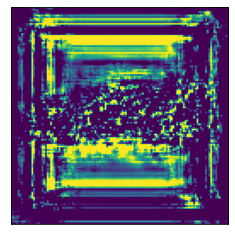

In [62]:
show(output[0])

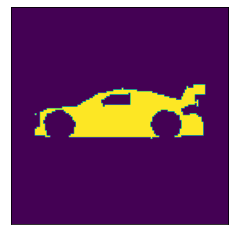

In [63]:
show(mask[0])